# <center> Приемы и подводные камни при обработке текстов на примере sentiment analisys. 

Рассмотрим как влияют различные преобразования текстов и подбор параметров CountVectorizer на результаты sentiment analysis(анализ настроения) на примере применения логистической регрессии. 

Напомню, что эта задача является крайне актуальной везде, где необходимо понять, является ли данный отзыв положительным или отрицательным. 

Возьмем тренировочный датасет labeledTrainData.tsv из вот этого [соревнования Kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). Там же можно ознакомиться с подробным описанием их содержимого. 

Для анализа данных текстов, представим их в виде векторов, посчитав частотность слов с помощью CountVectorizer). Сфомируем на основе нашего тренировочного датасета "labeledTrainData.tsv" объект Pandas.

In [182]:
import re
#import logging
#import time

from bs4 import BeautifulSoup

import numpy as np
import pandas as pd      

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt

In [183]:
train = pd.read_csv("labeledTrainData.tsv/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)
#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

Посмотрим на структуру данного датасета:

In [184]:
train.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [186]:
train.shape

(25000, 3)

Данный датасет содержит 25000 строк. Для экономии времени и ресурсов,попробуем его уменьшить, не ухудшая качетсво (пропорции между количеством положительных и отрицательных отзывов)

Определим списки индексов положительных и отрицательных отзывов:

In [5]:
idx_pos=[]#индексы позитивных текстов
idx_neg=[]#индексы негативных текстов
for i in range(train.shape[0]):
    if train["sentiment"][i]==1:
        idx_pos.append(i)
    else:
        idx_neg.append(i)        

In [6]:
len(idx_pos)#ровно половина

12500

Мы видим, что у нас равное количество положительных и отрицательных отзывов.  возьмем по 3000 положительных и отрицательных отзывов из train. Все результаты преобразований будем проверять на логистической регрессии.

Отберем по 3000 положительных и отрицательных отзывов и запишем их по этом порядке в общий список train_reviews

In [187]:

num_reviews = 3000
train_reviews = []
k=0
for i in (idx_pos):
    if k<num_reviews:
        train_reviews.append( train["review"][i] )# list of processed pos reviews
        k+=1
    else: break     
k=0
for i in (idx_neg):
    if k<num_reviews:
        train_reviews.append(train["review"][i] )# list of processed neg reviews
        k+=1
    else: break      

В этом случае мы можем составить список значений целевой переменной на это выборке как: 

In [138]:
sentiments = [1]*num_reviews+[0]*num_reviews

#### №1 Не делаем никаких специальных преобразований - получаем baseline виде roc_auc_score = 0.9331393769356535

In [189]:
def get_auc_lr_valid(X, y, C=1.0, seed=17,test_size=0.3):
    X_train,y_train  = X,y
    X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)
    logit = LogisticRegression(C=C, random_state=seed)
    logit.fit(X_train_part, y_train_part)
    logit_valid_pred = logit.predict_proba(X_valid)[:, 1]
    score = roc_auc_score(y_valid, logit_valid_pred)
    
    return score

In [190]:
vectorizer1 = CountVectorizer(analyzer = "word") 
train_data_features1 = vectorizer1.fit_transform(train_reviews)
train_data_features1 = train_data_features1.toarray()

Мы получили матрицу признаков размером 42249

In [192]:
pd.DataFrame(train_data_features1).shape

(6000, 42249)

In [193]:
score = get_auc_lr_valid(train_data_features1, sentiments)
score

0.9331393769356535

#### №2 Добавим параметр n_gram_range (и ограничим сразу число max_features, чтобы не вылетать по памяти).
Ограничение, кстати, надо делать очень аккуратно, т.к. при введении этой константы,  результат может как улучшиться, так и  ухудшиться, по сравнению с базовым. Посмотрим,что получится при применении разных таких ограничений. 

In [195]:
from tqdm import tqdm_notebook

In [196]:
#посмотрим, как поведет себя результат для различных значений max_features
scores=[]
max_f=range(5000,45000,5000)

for max_features in tqdm_notebook(max_f):
    vectorizer2 = CountVectorizer(analyzer = "word",ngram_range=[1,2],max_features=max_features) 
    train_data_features2 = vectorizer2.fit_transform(train_reviews)
    scores.append(get_auc_lr_valid(train_data_features2.toarray(), sentiments))

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [194]:
import gc
gc.collect()

4548

In [198]:
scores

[0.93098700426276,
 0.9377528389585629,
 0.9395433956858696,
 0.94069429145818,
 0.9415253567529921,
 0.9422070031760771,
 0.9426256229902544,
 0.9429874389358412]

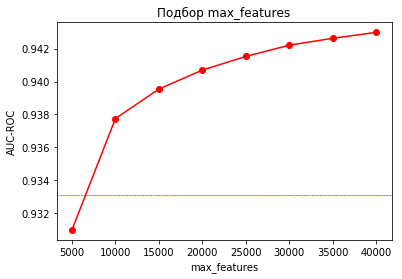

In [197]:
plt.plot(max_f, scores, 'ro-')
plt.xscale  ('linear')
plt.xlabel('max_features')
plt.ylabel('AUC-ROC')
plt.title('Подбор max_features')
# горизонтальная линия -- качество модели с коэффициентом по умолчанию
plt.axhline(y=score, linewidth=.5, color = 'b', linestyle='dashed') 
plt.show()

Таким образом, мы видим, что если взять max_features =5000, результат получится хуже,чем до введения n_grams.

#### Возьмем за следующий baseline максимальный полученный результат, roc_auc_score =0.9429874389358412 и зафиксируем max_features =40000 

#### №3 Уберем все символы, кроме латинских букв, передав функцию токенизации в CountVectorizer

In [173]:
def tokenizer1( raw_review ):
     # 1. Убираем HTML
    review_text = BeautifulSoup(raw_review,'lxml').get_text() 
    
    # 2. Убираем все символы, не являющиеся буквами. 
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3. Cоздадим список слов
    words = letters_only.split()        
    
    meaningful_words = [w for w in words]  
    return meaningful_words
     

In [174]:
vectorizer3_1 = CountVectorizer(analyzer = "word",ngram_range=[1,2],max_features=40000,tokenizer=tokenizer1) 
train_data_features3 = vectorizer3_1.fit_transform(train_reviews)


In [175]:
get_auc_lr_valid(train_data_features3.toarray(), sentiments)

0.94340482388331

#### Результат улучшился и составил roc_auc_score = 0.94340482388331

Теперь сделаем такую же очистку вручную, подав Count_Vectorizer на вход уже очищенные данные

In [176]:
def review_to_string( raw_review ):
    # 1. Убираем HTML
    review_text = BeautifulSoup(raw_review,'lxml').get_text() 
    
    # 2. Убираем все символы, не являющиеся буквами. 
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3. Cоздадим список слов
    words = letters_only.split()                             
    
    meaningful_words = [w for w in words]   
    
    # 4. Переведем список в строку, состоящую из слов, разделенных пробелом
    return( " ".join( meaningful_words ))   

Но для этого придется снова формировать наш train set - train_reviews_clean

In [177]:
num_reviews = 3000
train_reviews_clean = []
k=0
for i in (idx_pos):
    if k<num_reviews:
        train_reviews_clean.append(review_to_string( train["review"][i]) )# list of processed pos reviews
        k+=1
    else: break     
k=0
for i in (idx_neg):
    if k<num_reviews:
        train_reviews_clean.append(review_to_string(train["review"][i]))# list of processed neg reviews
        k+=1
    else: break      

In [178]:
vectorizer3_2 = CountVectorizer(analyzer = "word",ngram_range=[1,2],max_features=40000) 
train_data_features3 = vectorizer3_2.fit_transform(train_reviews_clean)
get_auc_lr_valid(train_data_features3.toarray(), sentiments)

0.9437382378946015

#### Результат еще улучшился! 
Получается, что очистка данных на входе работает лучше, чем передача такой функции в tokenizer. 
Наш новый baseline 0.9437382378946015

#### №4 Добавим стандартные stop_words

In [26]:
import nltk
from nltk.corpus import stopwords 
stops=stopwords.words("english")

In [160]:
vectorizer4_1 = CountVectorizer(analyzer = "word",ngram_range=[1,2],max_features=40000,stop_words=stops) 
train_data_features4 = vectorizer4_1.fit_transform(train_reviews_clean)
get_auc_lr_valid(train_data_features4.toarray(), sentiments)

0.9387086257909321

#### Вопреки ожиданиям, результат ухудшился!

In [ ]:
Почистим стоп-слова вручную, предварительно переведя весь текст в lower_case. Также уберем слова длиной менее 2.

In [169]:
def review_to_string2( raw_review ):
    # 1. Убираем HTML
    review_text = BeautifulSoup(raw_review,'lxml').get_text() 
    
    # 2. Убираем все символы, не являющиеся буквами. 
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3. Переведем в нижний регистр и создадим список слов
    words = letters_only.lower().split()                             
    #
    # 4. Для ускорения работы в Питоне, переведем стоп-слова из формата list в формат set.  
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Уберем все стоп-слова (т.е. слова,слова, знаки, символы, которые самостоятельно не несут никакой смысловой нагрузки)
    meaningful_words = [w for w in words if (not w in stops) and len(w)>2]   
    #
    # 6. Переведем список в строку, состоящую из слов, разделенных пробелом
    return( " ".join( meaningful_words )) 

In [ ]:
Снова применим данное преобразование к начальному датасету:

In [170]:
num_reviews = 3000
train_reviews_clean2 = []
k=0
for i in (idx_pos):
    if k<num_reviews:
        train_reviews_clean2.append(review_to_string2( train["review"][i]) )# list of processed pos reviews
        k+=1
    else: break     
k=0
for i in (idx_neg):
    if k<num_reviews:
        train_reviews_clean2.append(review_to_string2(train["review"][i]))# list of processed neg reviews
        k+=1
    else: break  

In [171]:
vectorizer4_2 = CountVectorizer(analyzer = "word",ngram_range=[1,2],max_features=40000) 
train_data_features4 = vectorizer4_2.fit_transform(train_reviews_clean2)
get_auc_lr_valid(train_data_features4.toarray(), sentiments)

0.9393149453447995

#### Результат ручной чистки стоп-слов оказался лучше, чем автоматической, но, вопреки ожиданиям, убирание стоп-слов ухудшило результат!

#### №5 Попробуем применить стемминг.
Добавим ее в нашу функцию преобразования данных. 

In [204]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [214]:
def review_to_string3( raw_review ):
    # 1. Убираем HTML
    review_text = BeautifulSoup(raw_review,'lxml').get_text() 
    
    # 2. Убираем все символы, не являющиеся буквами. 
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # 3. Переведем в нижний регистр и создадим список слов
    words = letters_only.lower().split()  
    
            
    # 4. Применим стемминг
    meaningful_words = [stemmer.stem(w) for w in words if len(w)>2]   
    
    # 5. Переведем список в строку, состоящую из слов, разделенных пробелом
    return( " ".join( meaningful_words )) 


Снова применим данное преобразование к начальному датасету:

In [215]:
num_reviews = 3000
train_reviews_clean3 = []
k=0
for i in (idx_pos):
    if k<num_reviews:
        train_reviews_clean3.append(review_to_string3( train["review"][i]) )# list of processed pos reviews
        k+=1
    else: break     
k=0
for i in (idx_neg):
    if k<num_reviews:
        train_reviews_clean3.append(review_to_string3(train["review"][i]))# list of processed neg reviews
        k+=1
    else: break  

In [216]:
vectorizer5 = CountVectorizer(analyzer = "word",ngram_range=[1,2],max_features=40000) 
train_data_features5 = vectorizer5.fit_transform(train_reviews_clean3)
get_auc_lr_valid(train_data_features5.toarray(), sentiments)

0.9442309497112883

### Результат снова улучшился!
Таким образом, с потощью стемминга нам удалось повысить roc_auc_score до 0.9442309497112883

### Таким образом, с помощью проделанных выше преобразований нам удалось повысить нашу метрику качества roc_auc_score  с базового уровня 0.933 до 0.944

Использованные материалы:
http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
http://nbviewer.jupyter.org/github/MatthieuBizien/Bag-popcorn/blob/master/Kaggle-Word2Vec.ipynbhttps://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1


In [ ]:
Автор:Доможирова Наталья Николаевна (dnn37@mail.ru)